![Forecasting UK Mortgage Rates](resources/images/banner.png)

# End-to-End Machine Learning Pipeline for Forecasting UK Mortgage Rates
## Overview
UK mortgage rates directly impact affordability, re-financing decisions, and lender risk management. The objective of this project is to build a machine learning pipeline that forecasts short-term mortgage rate movements to support decisions such as re-financing timing, product pricing, and risk assessment.

The project demonstrates a complete end-to-end workflow from data acquisition to model evaluation and can be converted into a production-ready pipeline.

## 1. Data Loading & Preprocessing
In this section, we'll import the relevant libraries and load CSVs, clean column names, convert dates and align monthly data, finalizing with merging all the dataframes into one so we can proceed with our analysis.

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Loading the dataframes
fixed_2 = pd.read_csv('resources/data/2y_fixed.csv')
fixed_5 = pd.read_csv('resources/data/5y_fixed.csv')
base_rate = pd.read_csv('resources/data/BoE_base_rate.csv')
cpih = pd.read_csv('resources/data/Inflation(CPIH).csv')

# Confirming load
display(fixed_2.head())
display(fixed_5.head())
display(base_rate.head())
display(cpih.head(10))

,Date,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 2 year (95% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [a] [b] [c] IUM2WTL,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 2 year (90% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [d] [e] [b] [c] IUMB482,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 2 year (75% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [a] [d] [b] [c] IUMBV34,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 2 year (60% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [b] [c] IUMZICQ
0,31 Dec 25,4.83,4.42,3.97,3.78
1,30 Nov 25,4.91,4.49,4.06,3.91
2,31 Oct 25,5,4.57,4.20,4.03
3,30 Sep 25,5.03,4.58,4.19,4.03
4,31 Aug 25,5,4.55,4.10,3.93


,Date,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 5 year (95% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [a] [b] [c] [d] IUM5WTL,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 5 year (75% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [a] [b] [c] [d] IUMBV42,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 5 year (60% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [d] IUMZO27,Monthly interest rate of UK monetary financial institutions (excl. Central Bank) sterling 5 year (90% LTV) fixed rate mortgage to households (in percent) not seasonally adjusted [d] IUMZO28
0,31 Dec 25,4.76,4.00,3.88,4.35
1,30 Nov 25,4.82,4.07,3.96,4.41
2,31 Oct 25,4.89,4.17,4.10,4.50
3,30 Sep 25,4.9,4.16,4.07,4.51
4,31 Aug 25,4.86,4.11,4.03,4.43


,Date,Bank Rate
0,28-02-2003,3.75
1,03-03-2003,3.75
2,04-03-2003,3.75
3,05-03-2003,3.75
4,06-03-2003,3.75


,Title,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100
0,CDID,L55O
1,Source dataset ID,MM23
2,PreUnit,NaN
3,Unit,%
4,Release date,21-01-2026
5,Next release,18 February 2026
6,Important notes,NaN
7,2003 MAR,1.6
8,2003 APR,1.5
9,2003 MAY,1.3


From this initial assessment, it's noticeable that some care has to be had with the column names, which for the two dataframes are too long. The proper data on the dataframe `cpih` only starts from row 7, with generic information on the first 6 rows, which can be safely removed.

In [2]:
# Renaming the necessary columns
fixed_2 = fixed_2.rename(columns = {fixed_2.columns[1]: '95_LTV_2y', 
                                    fixed_2.columns[2]: '90_LTV_2y',
                                    fixed_2.columns[3]: '75_LTV_2y',
                                    fixed_2.columns[4]: '60_LTV_2y'})
fixed_5 = fixed_5.rename(columns = {fixed_5.columns[1]: '95_LTV_5y',
                                    fixed_5.columns[2]: '75_LTV_5y',
                                    fixed_5.columns[3]: '60_LTV_5y',
                                    fixed_5.columns[4]: '90_LTV_5y'})
cpih = cpih.rename(columns = {cpih.columns[0]: 'Date', cpih.columns[1]: 'CPIH'})

# Removing the first 7 rows of cpih
cpih = cpih.drop(index = cpih.index[:7]).reset_index(drop = True)

display(fixed_2.head(3))
display(fixed_5.head(3))
display(base_rate.head(3))
display(cpih.head(3))

,Date,95_LTV_2y,90_LTV_2y,75_LTV_2y,60_LTV_2y
0,31 Dec 25,4.83,4.42,3.97,3.78
1,30 Nov 25,4.91,4.49,4.06,3.91
2,31 Oct 25,5,4.57,4.20,4.03


,Date,95_LTV_5y,75_LTV_5y,60_LTV_5y,90_LTV_5y
0,31 Dec 25,4.76,4.00,3.88,4.35
1,30 Nov 25,4.82,4.07,3.96,4.41
2,31 Oct 25,4.89,4.17,4.10,4.50


,Date,Bank Rate
0,28-02-2003,3.75
1,03-03-2003,3.75
2,04-03-2003,3.75


,Date,CPIH
0,2003 MAR,1.6
1,2003 APR,1.5
2,2003 MAY,1.3


Now that our dataframes are starting to gain shape, we'll proceed by running `info()` on the dataframes, as that lets us see if there are missing entries, and also if the column data types are aligned with what would be expected.

In [3]:
# Checking information on the dataframes
print('\nFixed 2 years:')
print(fixed_2.info())
print('\nFixed 5 years:')
print(fixed_5.info())
print('\nBase Rate:')
print(base_rate.info())
print('\nPCIH:')
print(cpih.info())


Fixed 2 years:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       276 non-null    object 
 1   95_LTV_2y  276 non-null    object 
 2   90_LTV_2y  212 non-null    object 
 3   75_LTV_2y  276 non-null    float64
 4   60_LTV_2y  168 non-null    float64
dtypes: float64(2), object(3)
memory usage: 10.9+ KB
None

Fixed 5 years:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       276 non-null    object 
 1   95_LTV_5y  276 non-null    object 
 2   75_LTV_5y  276 non-null    float64
 3   60_LTV_5y  83 non-null     float64
 4   90_LTV_5y  83 non-null     float64
dtypes: float64(3), object(2)
memory usage: 10.9+ KB
None

Base Rate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 579

It seems that all of the `Date` columns are appearing as object `type`, so we;'ll need to convert to datetime objects, and also looking at the fixed-rates dataframes, some columns that were expected to be `float` are currently `objeect`, this means that there might be NaN or non-numeric values, so we'll need to verify. 

In [4]:
# Converting all columns to numeric and counting how many values are either NaN or non-numeric
rate_cols_2 = fixed_2.columns.drop('Date')
coerced_2 = fixed_2[rate_cols_2].apply(pd.to_numeric, errors="coerce")
missing_mask_2 = coerced_2.isna() & fixed_2.notna()
print('2 Year fixed-rate:\n', missing_mask_2.sum())

rate_cols_5 = fixed_5.columns.drop('Date')
coerced_5 = fixed_5[rate_cols_5].apply(pd.to_numeric, errors="coerce")
missing_mask_5 = coerced_5.isna() & fixed_5.notna()
print('5 Year fixed-rate:\n', missing_mask_5.sum())

# Joining it all back again
fixed_2[rate_cols_2] = coerced_2
fixed_5[rate_cols_5] = coerced_5

2 Year fixed-rate:
 60_LTV_2y     0.0
75_LTV_2y     0.0
90_LTV_2y     3.0
95_LTV_2y    65.0
Date          0.0
dtype: float64
5 Year fixed-rate:
 60_LTV_5y     0.0
75_LTV_5y     0.0
90_LTV_5y     0.0
95_LTV_5y    61.0
Date          0.0
dtype: float64


Numeric coercion was applied to all mortgage rate series.<br>
Values failing conversion while remaining present in the raw data were identified as placeholder entries denoting unavailable observations.<br>
These values were subsequently treated as missing during preprocessing.<br>
Among available LTV bands, both 60% and 75% LTV series were fully observed across 2-year and 5-year products.<br>
The 75% LTV series was selected as the primary modelling target due to its widespread use as a market benchmark and greater sensitivity to macroeconomic conditions.

The next step is then to clean the `Date` columns and format them the same way across all dataframes, this allows proper time-aware processing, indexing, and alignment across datasets. The CPIH series required a custom format due to "YYY MMM" strings.

In [5]:
# Converting all `Dates` to datetime
fixed_2['Date'] = fixed_2['Date'].apply(pd.to_datetime, dayfirst = True)
fixed_5['Date'] = fixed_5['Date'].apply(pd.to_datetime, dayfirst = True)
base_rate['Date'] = base_rate['Date'].apply(pd.to_datetime, dayfirst = True)
cpih['Date'] = cpih['Date'].apply(pd.to_datetime, format='%Y %b')

# Confirming changes applied as predicted
display(fixed_2.head(3))
print(fixed_2.dtypes)

,Date,95_LTV_2y,90_LTV_2y,75_LTV_2y,60_LTV_2y
0,2025-12-31,4.83,4.42,3.97,3.78
1,2025-11-30,4.91,4.49,4.06,3.91
2,2025-10-31,5.00,4.57,4.20,4.03


Date         datetime64[ns]
95_LTV_2y           float64
90_LTV_2y           float64
75_LTV_2y           float64
60_LTV_2y           float64
dtype: object


We can now group `base_rate` by month, and then remove all the days from the `Date` column, keeping the formatting the same across all dataframes.

In [6]:
# Grouping by Month
base_rate_monthly = base_rate.groupby(base_rate['Date'].dt.to_period('M').rename('Month')).mean().reset_index()

# Convert Period back to datetime at start of month
base_rate_monthly['Date'] = base_rate_monthly['Month'].dt.to_timestamp()
base_rate_monthly.drop(columns='Month', inplace=True)

# Dropping day from all dataframes
fixed_2['Date'] = fixed_2['Date'].dt.to_period('M').dt.to_timestamp()
fixed_5['Date'] = fixed_5['Date'].dt.to_period('M').dt.to_timestamp()
base_rate_monthly['Date'] = base_rate_monthly['Date'].dt.to_period('M').dt.to_timestamp()
cpih['Date'] = cpih['Date'].dt.to_period('M').dt.to_timestamp()


display(base_rate_monthly.head())
display(fixed_2.head())
display(fixed_5.head())
cpih.head()

,Date,Bank Rate
0,2003-02-01,3.75
1,2003-03-01,3.75
2,2003-04-01,3.75
3,2003-05-01,3.75
4,2003-06-01,3.75


,Date,95_LTV_2y,90_LTV_2y,75_LTV_2y,60_LTV_2y
0,2025-12-01,4.83,4.42,3.97,3.78
1,2025-11-01,4.91,4.49,4.06,3.91
2,2025-10-01,5.00,4.57,4.20,4.03
3,2025-09-01,5.03,4.58,4.19,4.03
4,2025-08-01,5.00,4.55,4.10,3.93


,Date,95_LTV_5y,75_LTV_5y,60_LTV_5y,90_LTV_5y
0,2025-12-01,4.76,4.00,3.88,4.35
1,2025-11-01,4.82,4.07,3.96,4.41
2,2025-10-01,4.89,4.17,4.10,4.50
3,2025-09-01,4.90,4.16,4.07,4.51
4,2025-08-01,4.86,4.11,4.03,4.43


,Date,CPIH
0,2003-03-01,1.6
1,2003-04-01,1.5
2,2003-05-01,1.3
3,2003-06-01,1.2
4,2003-07-01,1.3


The preprocessing for our datasets is almost complete, the last step is to join all the dataframes into a single one with all the information necessary.<br>
The datasets will be merged on month-start dates, retaining only the target series (75% LTV mortgage rate) and relevant macroeconomic features (Bank Rate and CPIH). This produces a single, time-aligned table for modeling.<br>
Two dataframes were created, so we can proceed with the analysis of both a 2 year and a 5 year fixed rate for mortgages with 75% LTV without risking information being leaked between the rates or compromising the predictions. An inner join was used to ensure all series share a common observation window, preventing implicit forward-filling or extrapolation across datasets.

In [7]:
# Joining all the dataframes / Inner was selected to make sure the time period is the same across all columns
# 2 year fixed
df_2 = fixed_2[['Date', '75_LTV_2y']].merge(
    base_rate_monthly[['Date', 'Bank Rate']],
    on='Date',
    how='inner'
).merge(
    cpih[['Date', 'CPIH']],
    on='Date',
    how='inner'
)
# 5 year fixed
df_5 = fixed_5[['Date', '75_LTV_5y']].merge(
    base_rate_monthly[['Date', 'Bank Rate']],
    on='Date',
    how='inner'
).merge(
    cpih[['Date', 'CPIH']],
    on='Date',
    how='inner'
)

# Sorting the Dated from older to newer
df_2 = df_2.sort_values('Date')
df_5 = df_5.sort_values('Date')

# Setting the `Date` as the index so resampling and plotting are easier 
df_2.set_index('Date', inplace=True)
df_5.set_index('Date', inplace=True)

# Confirming
print(df_2.head())
print(df_5.info())

            75_LTV_2y  Bank Rate CPIH
Date                                 
2003-03-01       4.06   3.750000  1.6
2003-04-01       4.06   3.750000  1.5
2003-05-01       3.91   3.750000  1.3
2003-06-01       3.85   3.750000  1.2
2003-07-01       3.87   3.576087  1.3
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 2003-03-01 to 2025-12-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   75_LTV_5y  274 non-null    float64
 1   Bank Rate  274 non-null    float64
 2   CPIH       274 non-null    object 
dtypes: float64(2), object(1)
memory usage: 8.6+ KB
None


## 2. Feature Engineering 
We'll now proceed with creating lagged mortage rates so we can capture the persistance of the housing market in relation to current market trends and a short-term rolling mean to capture short-term trends, and finally create our feature and target variables. <br>
On this project, two target variables will be used, one for a fixed 2-year fixed rate with 75% LTV, and another for a fixed 5-year fixed rate with 75% LTV.

In [8]:
# Lagged Mortgage rates
# 2 year
df_2['mortgage_lag_1'] = df_2['75_LTV_2y'].shift(1)
df_2['mortgage_lag_3'] = df_2['75_LTV_2y'].shift(3)

# 5 year
df_5['mortgage_lag_1'] = df_5['75_LTV_5y'].shift(1)
df_5['mortgage_lag_3'] = df_5['75_LTV_5y'].shift(3)

# Rolling mean
df_2['mortgage_roll_3'] = df_2['75_LTV_2y'].rolling(window=3).mean()
df_5['mortgage_roll_3'] = df_5['75_LTV_5y'].rolling(window=3).mean()

# Drop rows with NaNs created by the lagged rates
df_2_fe = df_2.dropna().copy()
df_5_fe = df_5.dropna().copy()

# Creating feature and target dataframes
# 2 year
X_2 = df_2_fe[['Bank Rate', 'CPIH', 'mortgage_lag_1', 'mortgage_lag_3', 'mortgage_roll_3']]
y_2 = df_2_fe['75_LTV_2y']

# 5 year
X_5 = df_5_fe[['Bank Rate', 'CPIH', 'mortgage_lag_1', 'mortgage_lag_3', 'mortgage_roll_3']]
y_5 = df_5_fe['75_LTV_5y']

## 3. Train/Test Split
Train-test splits were performed after feature construction to preserve the temporal structure of lagged variables. To avoid future data compromising the trends, and random shuffling breaking causality, a time-aware split was used.

In [9]:
# Doing the train-test splits
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.2, shuffle = False)
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.2, shuffle = False)

## 4. Baseline Model
For baseline models, two will be compared, the first one, a naive model is used, which is already in place in the feature `mortgage_lag_1`. The second model will be a simple linear regression allowing us to see how the dataframe features impact the prediction. As evaluation metric, the Mean Absolute Error (MAE) will be used, as it directly reflects the average absolute error in mortgage rate percentage pounts, which is meaningful for pricinf and refinancing decisions. Root Mean Squared Error (RMSE) is used as a complementary metric to further help distinguish and evaluate the models.

Evaluation for 2 year fixed rate model:
MAE: 0.11138131555737822
RMSE: 0.036814740941192955


Evaluation for 5 year fixed rate model:
MAE: 0.09800817308591692
RMSE: 0.029741424673557514


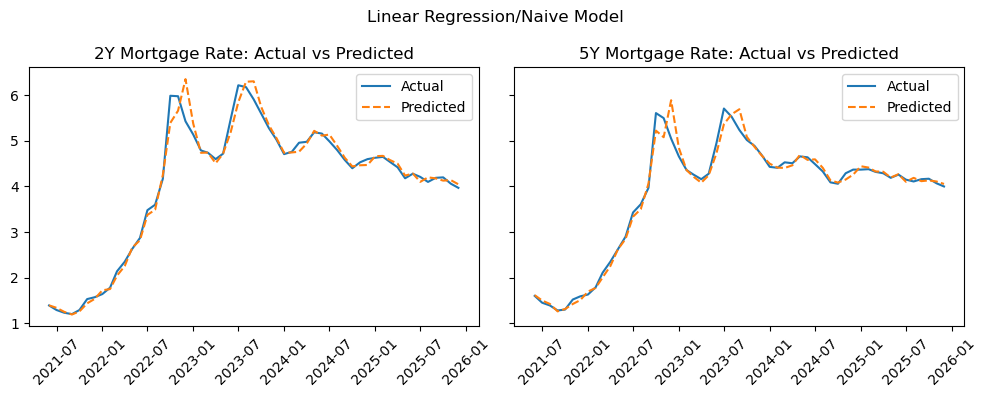

In [10]:
# Setting the Naive dataframes
y2_pred_naive = X2_test['mortgage_lag_1']
y5_pred_naive = X5_test['mortgage_lag_1']

# Training the models
model_2 = LinearRegression()
model_2.fit(X2_train, y2_train)

model_5 = LinearRegression()
model_5.fit(X5_train, y5_train)

# Making predictions
y2_pred = model_2.predict(X2_test)
y5_pred = model_5.predict(X5_test)

# Evaluating the models
print('Evaluation for 2 year fixed rate model:')
print('MAE:', mean_absolute_error(y2_test, y2_pred))
print('RMSE:', mean_squared_error(y2_test, y2_pred))
print('\n')
print('Evaluation for 5 year fixed rate model:')
print('MAE:', mean_absolute_error(y5_test, y5_pred))
print('RMSE:', mean_squared_error(y5_test, y5_pred))

# Visual representation
fig, (ax2, ax5) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4), sharey = True)
fig.suptitle('Linear Regression/Naive Model')
ax2.plot(y2_test.index, y2_test, label='Actual')
ax2.plot(y2_test.index, y2_pred, label='Predicted', linestyle = '--')
ax2.legend()
ax2.set_title('2Y Mortgage Rate: Actual vs Predicted')
ax2.tick_params(axis='x', rotation=45)

ax5.plot(y5_test.index, y5_test, label='Actual')
ax5.plot(y5_test.index, y5_pred, label='Predicted', linestyle = '--')
ax5.legend()
ax5.set_title('5Y Mortgage Rate: Actual vs Predicted')
ax5.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

An MAE for both variables close to 0.10 means that the model predicts the fixed mortgage rates with an error of up to 0.11 and 0.98 percentage points, the values of RMSE of close to 0.03 indicates that the predictions are very close to the actual, observed data points. Both metrics confirm that the predictions are fairly accurate.

## 5. Machine Learning Model: Random Forest
For the Machine Learning Model of this project, I've decided to go with a Random Forest, as it can capture non-linear relationships, it's robust to small datasets, and is suitable for tabular macroeconomic time-series features without extensive preprocessing.<br>
Hence, as on this project the Linear Regression is being used as a baseline, Random Forest will be used as a non-linear benchmark.

Evaluation for 2 year fixed rate model:
MAE: 0.24347979255462976
RMSE: 0.1181222079308293


Evaluation for 5 year fixed rate model:
MAE: 0.2341935083527126
RMSE: 0.13232193789797705


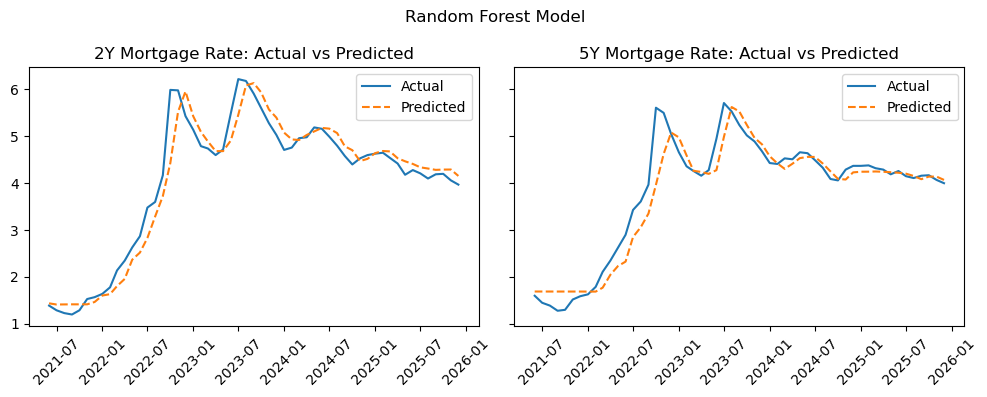

In [11]:
# Implementing the RandomForestRegressor
rfr_2y = RandomForestRegressor(random_state = 30,
                            n_estimators = 300,
                            max_depth = 5,
                            min_samples_leaf = 5)
rfr_5y = RandomForestRegressor(random_state = 30,
                            n_estimators = 300,
                            max_depth = 5,
                            min_samples_leaf = 5)

# Fitting and testing
rfr_2y.fit(X2_train, y2_train)
rfr_5y.fit(X5_train, y5_train)

y2_pred = rfr_2y.predict(X2_test)
y5_pred = rfr_5y.predict(X5_test)

# Evaluating the models
print('Evaluation for 2 year fixed rate model:')
print('MAE:', mean_absolute_error(y2_test, y2_pred))
print('RMSE:', mean_squared_error(y2_test, y2_pred))
print('\n')
print('Evaluation for 5 year fixed rate model:')
print('MAE:', mean_absolute_error(y5_test, y5_pred))
print('RMSE:', mean_squared_error(y5_test, y5_pred))

# Visual representation
fig, (ax2, ax5) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4), sharey = True)
fig.suptitle('Random Forest Model')
ax2.plot(y2_test.index, y2_test, label='Actual')
ax2.plot(y2_test.index, y2_pred, label='Predicted', linestyle = '--')
ax2.legend()
ax2.set_title('2Y Mortgage Rate: Actual vs Predicted')
ax2.tick_params(axis='x', rotation=45)

ax5.plot(y5_test.index, y5_test, label='Actual')
ax5.plot(y5_test.index, y5_pred, label='Predicted', linestyle = '--')
ax5.legend()
ax5.set_title('5Y Mortgage Rate: Actual vs Predicted')
ax5.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Random Forest regressors were trained separately for 2-year and 5-year fixed-rate targets, using identical hyperparameters to ensure comparability across horizons and were trained with constrained depth to reduce overfitting while capturing non-linear relationships between macroeconomic indicators and mortgage rates. Model randomness was controlled for reproducibility.<br>
The values achieved when computing the evaluation was worse for both the MAE and the RMSE, meaaning that despite its flexibility, the Random Forest underperformed relative to the linear baseline. This can also be checked visually through the plot as the predicted values in the Linear Regression Model more closelly follow the Actual values, when compared to the Random Forest Model. This suggests that the mortgage rates over the observed period are well approximated by linear relationships with macroeconomic variables and that additional model complecity introduces variance without improving predictive accuracy.

For the Random Forest model, some of its hyper-paramenters will now be fine tuned, as to verify if even with optimal values for this model, it still underperforms when compared to the Linear Regression Model.

Tuned RF – 2Y MAE: 0.2404408656671606
Tuned RF – 2Y RMSE: 0.3534794342539786
Tuned RF – 5Y MAE: 0.2116761898783031
Tuned RF – 5Y RMSE: 0.3104952569961051


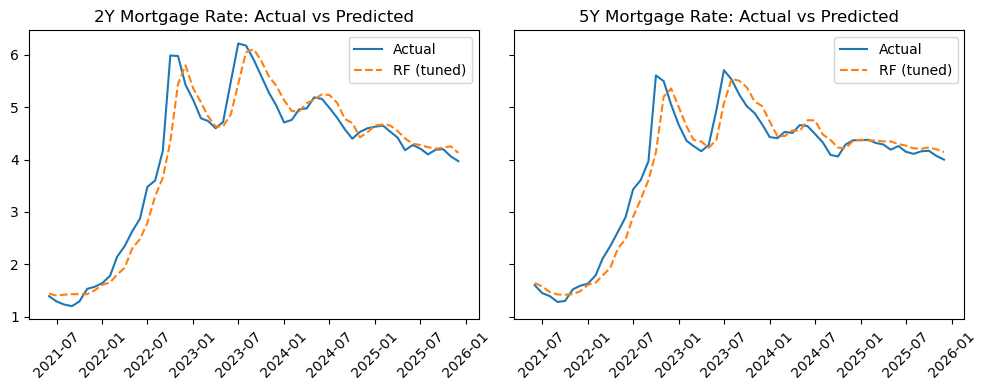

In [16]:
# Defining parameters to fine-tune
param_grid = {'n_estimators': [200, 500],
              'max_depth': [3, 5, 10, None],
              'min_samples_leaf': [1, 3, 5],
              'max_features': ['sqrt', 0.7]
             }

# Setting split to be used in GridSearch
'''As SearchGridCV searches randomly, data may leak from future to past and influence predictions.
    Due to this, need a way to do the gridsearch in a way that follows cronological order. >> use time series split
    (Similar to the train test split without shuffling, used before, but this makes it so instead of just a split at
    0.8/0.2, it makes different splits for each iteraction'''
tscv = TimeSeriesSplit(n_splits=5)

# GridSearch for 2y model
rfr_2y = RandomForestRegressor(random_state=42)

grid_2y = GridSearchCV(
    estimator=rfr_2y,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_2y.fit(X2_train, y2_train)

best_rfr_2y = grid_2y.best_estimator_

# Making prediction
y2_rfr_tuned = best_rfr_2y.predict(X2_test)

# GridSearch for 5y model
rfr_5y = RandomForestRegressor(random_state=42)


grid_5y = GridSearchCV(
    estimator=rfr_5y,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_5y.fit(X5_train, y5_train)

best_rfr_5y = grid_2y.best_estimator_

# Making prediction
y5_rfr_tuned = best_rfr_5y.predict(X5_test)

# Evaluating the models
mae_2 = mean_absolute_error(y2_test, y2_rfr_tuned)
rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_rfr_tuned))
mae_5 = mean_absolute_error(y5_test, y5_rfr_tuned)
rmse_5 = np.sqrt(mean_squared_error(y5_test, y5_rfr_tuned))

print(f"Tuned RF – 2Y MAE: {mae_2}")
print(f"Tuned RF – 2Y RMSE: {rmse_2}")
print(f"Tuned RF – 5Y MAE: {mae_5}")
print(f"Tuned RF – 5Y RMSE: {rmse_5}")

# Plotting results
fig, (ax2, ax5) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4), sharey = True)

ax2.plot(y2_test.index, y2_test, label='Actual')
ax2.plot(y2_test.index, y2_rfr_tuned, label='RF (tuned)', linestyle='--')
ax2.legend()
ax2.set_title('2Y Mortgage Rate: Actual vs Predicted')
ax2.tick_params(axis='x', rotation=45)


ax5.plot(y5_test.index, y5_test, label='Actual')
ax5.plot(y5_test.index, y5_rfr_tuned, label='RF (tuned)', linestyle='--')
ax5.legend()
ax5.set_title('5Y Mortgage Rate: Actual vs Predicted')
ax5.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

While a single train-test split preserves temporal order, TimeSeriesSplit provides a more robust evaluation by validating model performance across multiple historical forecasting windows, so it was used during hyperparameter tuning to preserve the temporal ordering of the data and prevent look-ahead bias, ensuring that model evaluation reflects a realistic forecasting setting.<br>
Hyperparameter tuning marginally improved Random Forest performance but did not close the gap with the linear regression benchmark. This suggests that the relationship between mortgage rates and macroeconomic drivers is largely linear over the observed period, and that tree-based models introduce unnecessary complexity. This suggests that mortgage rates are primarily driven by stable, approximately linear macroeconomic relationships rather than complex nonlinear interactions.

## 6. Model Evaluation
Compare predictions using metrics like MAE, RMSE
Model Saving & Inference Function – Save trained models and create a reusable prediction function
Conclusion